1D KNAPSACK PROBLEM WITH SPO+ PREDICTION

In [258]:
import time
import random
import pyepo
import torch
from matplotlib import pyplot as plt
from matplotlib import colormaps
import numpy as np
from tqdm import tqdm
from torch import nn

In [259]:
# fix random seed
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)

In [260]:
def visSol(data_loader, optmodel, ind=0, pytorch_model=None, method_name=None):
  # extract solutions by iterating over data loader (pytorch does not provide indexing into it)
  for i, data in enumerate(loader_test):
      if i == ind:
        # load data
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # convert to numpy
        c = c.to("cpu").detach().numpy()[0]
        w = w.to("cpu").detach().numpy()[0]
        z = z.to("cpu").detach().numpy()[0]
        # predict
        if pytorch_model is not None:
          cp = pytorch_model(x)
          cp = cp.to("cpu").detach().numpy()
          # solve
          optmodel.setObj(cp[0])
          wp, _ = optmodel.solve()
        else:
          cp = [None]
          wp = w
          method_name = "Groundtruth Optimal Solution"
        # plot
        fig = plotSol(m, c, wp, weights, caps, method_name, cp[0])
        break

In [261]:
# plot function
def plotSol(m, c, w, weights, caps, caption=None, cp=None):
    # colors
    cmap = colormaps["plasma"](np.linspace(0, 1, m))
    # get list
    sol, val, cap1, cap2, cpred = [], [], [], [], []
    for i in range(m):
        sol.append(3)
        val.append(c[i] * w[i])
        cap1.append(weights[0,i] * w[i])
        #cap2.append(weights[1,i] * w[i])
        if cp is not None:
          cpred.append(cp[i] * w[i])
    # init fig
    fig = plt.figure(figsize=(8,4))
    plt.gca().invert_yaxis()
    acc = [0, 0, 0]
    # bar plot
    if cp is None:
      for i in range(m):
          bar = [sol[i], val[i], cap1[i]]#, cap2[i]]
          plt.barh(range(3), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
          # not selected
          if not int(w[i]):
              # grey color
              bar = [sol[i], 0, 0]
              plt.barh(range(3), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
              plt.barh(range(3), bar, left=acc, color="lightgrey", height=0.75, edgecolor="w", linewidth=2, alpha=0.9)
          acc = [acc[0]+sol[i], acc[1]+val[i], acc[2]+cap1[i]]#, acc[3]+cap2[i]]
    else:
      acc = [0, 0, 0, 0]
      for i in range(m):
          bar = [sol[i], val[i], cpred[i], cap1[i]]#, cap2[i]]
          plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
          # not selected
          if not int(w[i]):
              # grey color
              bar = [sol[i], 0, 0, 0]
              plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
              plt.barh(range(4), bar, left=acc, color="lightgrey", height=0.75, edgecolor="w", linewidth=2, alpha=0.9)
          acc = [acc[0]+sol[i], acc[1]+val[i], acc[2]+cpred[i], acc[3]+cap1[i]]#, acc[4]+cap2[i]]
    # total value
    tval = sum(val)
    plt.text(tval+0.5, 1.1, tval, fontsize=12)
    # vertical line
    if cp is None:
      plt.axvline(x=caps[0], ymin=0.27, ymax=0.48, color="firebrick", linewidth=1.5)
      plt.text(caps[0]+0.5, 2.1, "Capacity 1", fontsize=12, color="firebrick")
    else:
      # total predicted value
      tpredval = sum(cpred)
      plt.text(tpredval+0.5, 2.1, "%.2f"%tpredval, fontsize=12)
      plt.axvline(x=caps[0], ymin=0.23, ymax=0.38, color="firebrick", linewidth=1.5)
      plt.text(caps[0]+0.5, 3.1, "Capacity 1", fontsize=12, color="firebrick")
    # labels and ticks
    plt.xticks([])
    bar_labels = ["Items Selection", "Items Predicted Value", "Resource 1"] if cp is None else ["Items Selection", "Items True Value", "Items Predicted Value", "Resource 1"]
    plt.yticks(range(len(bar_labels)), bar_labels, fontsize=16)
    plt.minorticks_off()
    plt.tick_params(axis='both', length=0)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.title(caption, fontsize=18)
    plt.show()
    return fig

In [262]:
def visLearningCurve(loss_log, regret_log):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)

    # draw plot for regret on test
    ax2.plot(regret_log, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(regret_log), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)

    plt.title("Learning Curve on Training Set", fontsize=16)
    plt.show()

In [263]:
# fix random seed
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)

# generate data for 1D knapsack
m = 10 # number of items
n = 1000 # number of data AKA number of ALPHAs
p = 2 * m # size of feature
deg = 2 # polynomial degree
dim = 1 # dimension of knapsack

weights = np.array([np.round(np.random.uniform(1, 3, m),2)])
caps = [6] # capacity
ni = np.random.uniform(-1, 1, m)
ei = np.random.uniform(-1, 1, m)    
alphas = np.random.uniform(-5, 15, n)
noise = 0.5  

real_values = []
for j in range(n):
    data_point = []
    for i in range(m):
        data_point.append(np.random.normal(ni[i]*ni[i] + ei[i] + ei[i]*ni[i], noise))   # non-linear combination of n[i] an e[i] with some noise

    real_values.append(data_point)     

ni_ei = []
for i in range(m):
    ni_ei.extend([ni[i], ei[i]])

x = np.tile(ni_ei, (n, 1))
c = np.array(real_values)

print(c.shape)
print(x.shape)



(1000, 10)
(1000, 20)


In [264]:
# data split
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=int(0.8*n), random_state=246)

In [265]:
optmodel = pyepo.model.grb.knapsackModel(weights, caps)

In [266]:
# get training data set
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
# get test data set
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)


Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 445.60it/s]


Optimizing for optDataset...


100%|██████████| 800/800 [00:01<00:00, 465.56it/s]


In [267]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [268]:
from torch import nn
# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)

    def forward(self, x):
        out = self.linear(x)
        return out

In [269]:
# a index of arbitrary instance to visualize
ind = 0

In [270]:
# train model
def trainModel(reg, loss_func, method_name, num_epochs=20, lr=5e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # log
    loss_log, regret_log = [], []
    for epoch in range(num_epochs):
        # load data
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            elif method_name in ["ptb", "pfy", "imle", "nce"]:
                loss = loss_func(cp, w)
            elif method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            elif method_name in ["2s", "ltr"]:
                loss = loss_func(cp, c)
            # record loss
            loss_log.append(loss.item())
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # record regrer
        if epoch % 2 == 0:
            regret = pyepo.metric.regret(reg, optmodel, loader_test)
            print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
            regret_log.append(regret)
            print(w[0])
            

                
    # plot
    visLearningCurve(loss_log, regret_log)

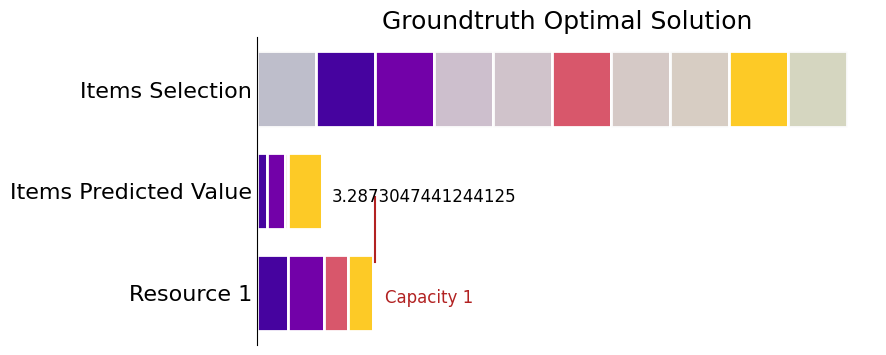

In [271]:
visSol(loader_test, optmodel, ind=ind, pytorch_model=None, method_name=None)

In [272]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 2
Epoch  0,  Loss:    1.8937,  Regret: 13.3852%
tensor([0., 1., 1., -0., 1., 0., 0., -0., 1., 0.])
Epoch  2,  Loss:    3.0261,  Regret: 13.3852%
tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 0.])
Epoch  4,  Loss:    2.7589,  Regret: 27.6893%
tensor([-0., -0., -0., 0., 0., 1., 0., 1., 1., 0.])
Epoch  6,  Loss:    1.9560,  Regret: 30.9036%
tensor([1., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
Epoch  8,  Loss:    2.0357,  Regret: 13.3852%
tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
Epoch 10,  Loss:    2.2234,  Regret: 29.4777%
tensor([1., 1., 0., -0., 1., 0., 0., -0., 1., 0.])
Epoch 12,  Loss:    2.0779,  Regret: 13.3852%
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 0.])
Epoch 14,  Loss:    2.0088,  Regret: 13.3852%
tensor([1., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
Epoch 16,  Loss:    2.9850,  Regret: 13.3852%
tensor([1., 1., 0., 0., 1., 0., 0., 0., 1., 0.])
Epoch 18,  Loss:    2.1341,  Regret: 13.3852%
tensor([0., 1., 1., 0., 0., 1., 0., 0., 1., 0.])


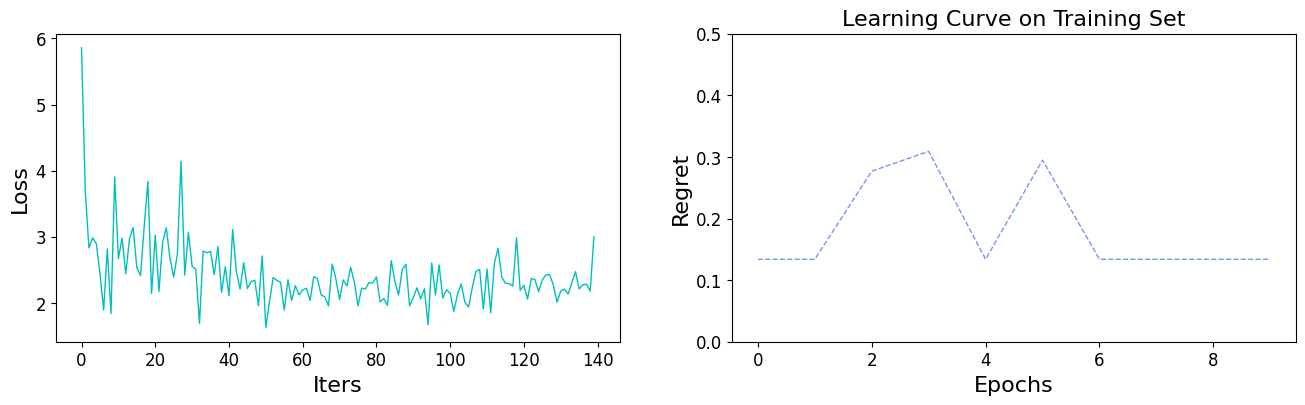

In [273]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(optmodel, processes=2)
# train
trainModel(reg, loss_func=spop, method_name="spo+")

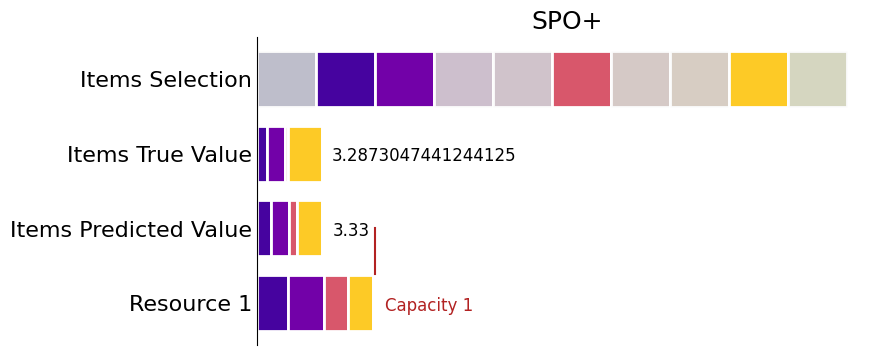

In [274]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="SPO+")